# Exploring vegetation change in Mali, Dogon Plateau from 2015 to 2023 

## Loading the necessary libraries

In [2]:
# rasterio: library for reading and writing geospatial raster data
import rasterio

# NumPy: library for numerical operations and array manipulation
import numpy as np

# matplotlib: library for creating visualizations and plots
import matplotlib.pyplot as plt

# pyproj: library for performing cartographic projections and transformations
from pyproj import Proj

# geopandas: library for working with geospatial data and geometry
import geopandas as gpd

# shapely: library for geometric operations and manipulations
from shapely.geometry import box, Point

# fiona: library for reading and writing geospatial vector data
from fiona.crs import from_epsg

# rasterio.mask: part of rasterio for masking raster datasets
from rasterio.mask import mask

# json: library for working with JSON data
import json

# os: library for interacting with the operating system (e.g., file paths)
import os

# folium: library for creating interactive maps
import folium

# scipy: library for scientific computing and statistical functions
from scipy import stats

# seaborn: library for statistical data visualization built on top of matplotlib
import seaborn as sns

# pandas: library for data manipulation and analysis, primarily for tabular data
import pandas as pd

# scipy.stats: submodule of SciPy for statistical tests and probability distributions
from scipy.stats import mannwhitneyu


## Reading in the Landsat objects for 2015 and 2023

In [3]:
#2023 rasters (taken from Landsat 8)
B2_2023 =rasterio.open("../Sahel/Data_2023/Oct23_SR_B2.TIF") #Blue
B3_2023 =rasterio.open("../Sahel/Data_2023/Oct23_SR_B3.TIF") #Green
B4_2023 =rasterio.open("../Sahel/Data_2023/Oct23_SR_B4.TIF") #Red
B5_2023 =rasterio.open("../Sahel/Data_2023/Oct23_SR_B5.TIF") #NIR

#2015 rasters (taken from Landsat 8)
B2_2015 =rasterio.open("../Sahel/Data_2015/Oct15_SR_B2.TIF") #Blue
B3_2015 =rasterio.open("../Sahel/Data_2015/Oct15_SR_B3.TIF") #Green
B4_2015 =rasterio.open("../Sahel/Data_2015/Oct15_SR_B4.TIF") #Red
B5_2015 =rasterio.open("../Sahel/Data_2015/Oct15_SR_B5.TIF") #NIR

In [4]:
num_bands = B2_2023.count
print(f'Number of bands in image: {num_bands}\n')

Number of bands in image: 1



Each raster object has one band. These need to be read in as NumPy 2-D arrays, as this represents data in a memory efficient way

## Reading in each raster object as a Numpy 2-D array

In [5]:
#2023 bands
B2_band23=B2_2023.read(1) #blue band
B3_band23=B3_2023.read(1) #green band
B4_band23=B4_2023.read(1) #red band
B5_band23=B5_2023.read(1) #nir band

#2015 bands
B2_band15=B2_2015.read(1) #blue band
B3_band15=B3_2015.read(1) #green band
B4_band15=B4_2015.read(1) #red band
B5_band15=B5_2015.read(1) #nir band

Only one band has been read for each object, as only one band is present

## Defining a function to convert from digitized to reflectance

In [6]:
def convert_to_reflectance(band):
    """
    Convert a band from digitized to reflectance.
     
     Parameters:
    - band (numpy.ndarray): The digitized band to be converted.

    Returns:
    - numpy.ndarray: The band in reflectance values.
    """
    
    mult_parameter = 0.0001 #This value is taken from the Earth Explorer website
    return band * mult_parameter

This is a crucial conversion which enhances the accuracy and comparability of remote sensing data 

## Converting the digitized bands to reflectance

In [7]:
#2023 conversions
blue_reflect23 = convert_to_reflectance(B2_band23) #blue
green_reflect23 = convert_to_reflectance(B3_band23) #green
red_reflect23 = convert_to_reflectance(B4_band23)#red
nir_reflect23 = convert_to_reflectance(B5_band23) #nir

#2015 conversions
blue_reflect15 = convert_to_reflectance(B2_band15) #blue
green_reflect15 = convert_to_reflectance(B3_band15) #green
red_reflect15 = convert_to_reflectance(B4_band15)#red
nir_reflect15 = convert_to_reflectance(B5_band15) #nir

In [8]:
#Checking the shape for each array

# Define bands and corresponding arrays
bands_2023 = {'blue': blue_reflect23, 'green': green_reflect23, 'red': red_reflect23, 'nir': nir_reflect23}
bands_2015 = {'blue': blue_reflect15, 'green': green_reflect15, 'red': red_reflect15, 'nir': nir_reflect15}

# Print shapes for 2023
for band, array in bands_2023.items():
    print(f"{band} shape in 2023: {array.shape}")

# Print shapes for 2015
for band, array in bands_2015.items():
    print(f"{band} shape in 2015: {array.shape}")

blue shape in 2023: (7781, 7631)
green shape in 2023: (7781, 7631)
red shape in 2023: (7781, 7631)
nir shape in 2023: (7781, 7631)
blue shape in 2015: (7781, 7621)
green shape in 2015: (7781, 7621)
red shape in 2015: (7781, 7621)
nir shape in 2015: (7781, 7621)


The arrays for 2023 and 2015 have slightly different shapes. If we want to analyse and compare the years, an ROI needs to be defined

Before an ROI is created, it is worthwile creating a true RGB image to understand what the data looks like. These can be plotted as normal RGB images

In [9]:
# Function to normalize the grid values
def normalize(array):
    """
    Normalizes numpy arrays into scale 0.0 - 1.0.

    Parameters:
    - array (numpy.ndarray): Input array to be normalized.

    Returns:
    - numpy.ndarray: Normalized array.
    """
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

# Normalize the bands

#2023
redn23 = normalize(red_reflect23)
greenn23 = normalize(green_reflect23)
bluen23 = normalize(blue_reflect23)

#2015
redn15 = normalize(red_reflect15)
greenn15 = normalize(green_reflect15)
bluen15 = normalize(blue_reflect15)
print("Normalized bands")

#2023
print(redn23.min(), '-', redn23.max(), 'mean:', redn23.mean())
print(greenn23.min(), '-', greenn23.max(), 'mean:', greenn23.mean())
print(bluen23.min(), '-', bluen23.max(), 'mean:', bluen23.mean())

#2015
print(redn15.min(), '-', redn15.max(), 'mean:', redn15.mean())
print(greenn15.min(), '-', greenn15.max(), 'mean:', greenn15.mean())
print(bluen15.min(), '-', bluen15.max(), 'mean:', bluen15.mean())

Normalized bands
0.0 - 1.0 mean: 0.2300728745574182
0.0 - 1.0 mean: 0.215250122574127
0.0 - 1.0 mean: 0.17530250034286562
0.0 - 1.0 mean: 0.25205304552179614
0.0 - 1.0 mean: 0.2384432911341053
0.0 - 1.0 mean: 0.2702743442276676


## Creating RGB natural color composites to visualise the raster layers

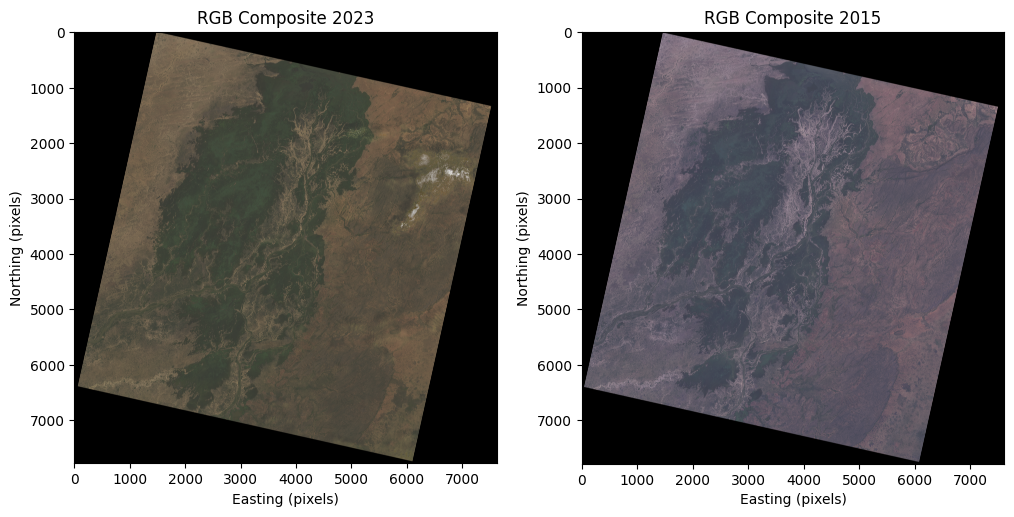

In [10]:
# Create RGB natural color composite using the np.dstack function for 2023
rgb23 = np.dstack((redn23, greenn23, bluen23))

# Create RGB natural color composite using the np.dstack function for 2015
rgb15 = np.dstack((redn15, greenn15, bluen15))

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Add Axis Labels and Colorbars
axes[0].set_xlabel('Easting (pixels)')
axes[0].set_ylabel('Northing (pixels)')
axes[1].set_xlabel('Easting (pixels)')
axes[1].set_ylabel('Northing (pixels)')


# Modify Titles
axes[0].set_title('RGB Composite 2023 - Natural Color')
axes[1].set_title('RGB Composite 2015 - Natural Color')

# Visualize the RGB color composite for 2023
axes[0].imshow(rgb23)
axes[0].set_title('RGB Composite 2023')

# Visualize the RGB color composite for 2015
axes[1].imshow(rgb15)
axes[1].set_title('RGB Composite 2015')

plt.show()

From a visual glance, it appears that the central part of the image is experiencing the most change. We are going to concentrate on this area for our analysis. Therefore, an ROI is required

## Defining a Region of Interest (ROI)

In [11]:
# Defining the latitude and longitude bounds for the ROI
Initial_longitude = -4.66
Final_longitude = -3.86
Initial_latitude = 13.80
Final_latitude = 15.02

#Creating an ROI
ROI=box(Initial_longitude,Initial_latitude,Final_longitude,Final_latitude)

Visualising the ROI on a folium map centered around the specified coordinates

In [12]:
# Create a folium map centered around the specified coordinates
map=folium.Map([14.45, -4],zoom_start=10)

# Adding the ROI to the map
folium.GeoJson(ROI).add_to(map)

# Displaying the map
map #Successful ROI achieved

Now we can create a GeoData frame with the specified geometry of 'ROI' using GeoPanda Libary

In [13]:
geo = gpd.GeoDataFrame({'geometry': ROI}, index=[0], crs=from_epsg(4326))

# Convert the GeoDataFrame to the CRS of B2_2023
geo = geo.to_crs(crs=B2_2023.crs)

# Extract coordinates from the GeoDataFrame
coords=[json.loads(geo.to_json())['features'][0]['geometry']]

We can now create a mask with a clipped image within the ROI for each raster

In [14]:
#2023 objects
out_img, out_transform = rasterio.mask.mask(B2_2023, coords, crop=True) #blue
out_img1, out_transform = rasterio.mask.mask(B3_2023, coords, crop=True) #green
out_img2, out_transform = rasterio.mask.mask(B4_2023, coords, crop=True) #red
out_img3, out_transform = rasterio.mask.mask(B5_2023, coords, crop=True) #nir

#2015 objects
out_img4, out_transform = rasterio.mask.mask(B2_2015, coords, crop=True) #blue
out_img5, out_transform = rasterio.mask.mask(B3_2015, coords, crop=True) #green
out_img6, out_transform = rasterio.mask.mask(B4_2015, coords, crop=True) #red
out_img7, out_transform = rasterio.mask.mask(B5_2015, coords, crop=True) #nir

We can now read the raster bands with the ROI applied

In [15]:
N=50 #This is removing 50 pixels around the margin of the image, to remove nan values

#2023 bands
blue_ROI23=out_img[0,N:-N,N:-N] #blue
green_ROI23=out_img1[0,N:-N,N:-N] #green
red_ROI23=out_img2[0,N:-N,N:-N] #red
nir_ROI23=out_img3[0,N:-N,N:-N] #nir

#2015 bands
blue_ROI15=out_img4[0,N:-N,N:-N] #blue
green_ROI15=out_img5[0,N:-N,N:-N] #green
red_ROI15=out_img6[0,N:-N,N:-N] #red
nir_ROI15=out_img7[0,N:-N,N:-N] #nir

Before continuing, we need to check that the array shapes are equal

In [16]:
# 2023
print("Blue 2023 shape:", blue_ROI23.shape)  # blue
print("Green 2023 shape:", green_ROI23.shape)  # green
print("Red 2023 shape:", red_ROI23.shape)  # red
print("NIR 2023 shape:", nir_ROI23.shape)  # nir

# 2015
print("Blue 2015 shape:", blue_ROI15.shape)  # blue
print("Green 2015 shape:", green_ROI15.shape)  # green
print("Red 2015 shape:", red_ROI15.shape)  # red
print("NIR 2015 shape:", nir_ROI15.shape)  # nir

Blue 2023 shape: (4416, 2801)
Green 2023 shape: (4416, 2801)
Red 2023 shape: (4416, 2801)
NIR 2023 shape: (4416, 2801)
Blue 2015 shape: (4416, 2801)
Green 2015 shape: (4416, 2801)
Red 2015 shape: (4416, 2801)
NIR 2015 shape: (4416, 2801)


This confirms that the ROI application was successful as all of the arrays have equal dimensions.

We need to convert these bands into reflectance, using the function defined from earlier

In [17]:
#2023 conversions
blue_ROI_reflect23 = convert_to_reflectance(blue_ROI23) #blue
green_ROI_reflect23 = convert_to_reflectance(green_ROI23) #green
red_ROI_reflect23 = convert_to_reflectance(red_ROI23)#red
nir_ROI_reflect23 = convert_to_reflectance(nir_ROI23) #nir

#2015 conversions
blue_ROI_reflect15 = convert_to_reflectance(blue_ROI15) #blue
green_ROI_reflect15 = convert_to_reflectance(green_ROI15) #green
red_ROI_reflect15 = convert_to_reflectance(red_ROI15)#red
nir_ROI_reflect15 = convert_to_reflectance(nir_ROI15) #nir

Visualising all of the bands

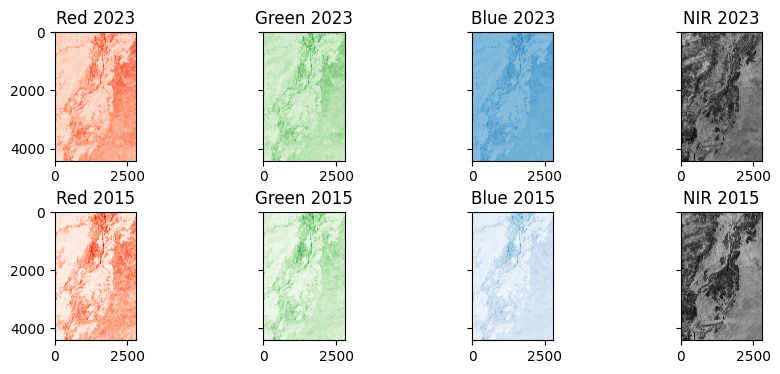

In [18]:
# Initialize subplots 
fig, ((ax1, ax2, ax3, ax7), (ax4, ax5, ax6, ax8)) = plt.subplots(ncols=4, nrows=2, figsize=(10, 4), sharey=True)

#Plotting all the bands
ax1.imshow(red_ROI_reflect23, cmap='Reds')
ax2.imshow(green_ROI_reflect23, cmap='Greens')
ax3.imshow(blue_ROI_reflect23, cmap='Blues')
ax4.imshow(red_ROI_reflect15, cmap='Reds')
ax5.imshow(green_ROI_reflect15, cmap='Greens')
ax6.imshow(blue_ROI_reflect15, cmap='Blues')
ax7.imshow(nir_ROI_reflect23, cmap='gray')
ax8.imshow(nir_ROI_reflect15, cmap='gray')

# Add titles
ax1.set_title("Red 2023")
ax2.set_title("Green 2023")
ax3.set_title("Blue 2023")
ax4.set_title("Red 2015")
ax5.set_title("Green 2015")
ax6.set_title("Blue 2015")
ax7.set_title("NIR 2023")
ax8.set_title("NIR 2015")

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.4, hspace=0.4)  # Adjust the width and height space

plt.show()  # Display the plot

Looking at the histogram for each band

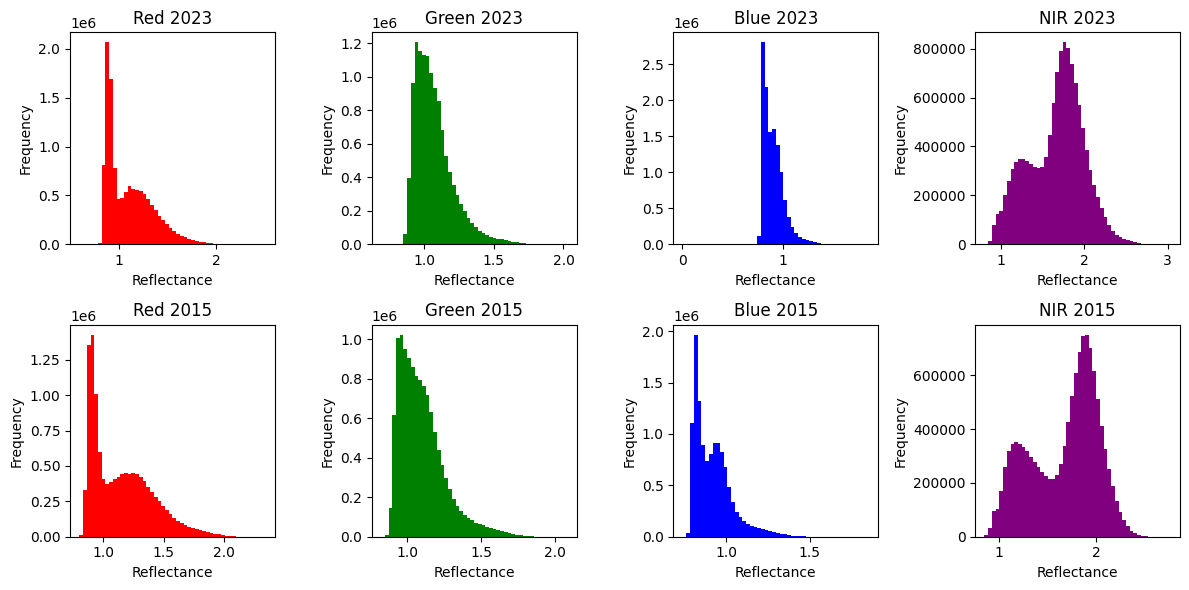

In [19]:
nbins = 50

# Create a single figure with 2 rows and 4 columns for the histograms
plt.figure(figsize=(12, 6))

# Red 2023
plt.subplot(2, 4, 1)
plt.hist(red_ROI_reflect23.ravel(), color="red", bins=nbins)
plt.xlabel("Reflectance")
plt.ylabel("Frequency")
plt.title("Red 2023")

# Green 2023
plt.subplot(2, 4, 2)
plt.hist(green_ROI_reflect23.ravel(), color="green", bins=nbins)
plt.xlabel("Reflectance")
plt.ylabel("Frequency")
plt.title("Green 2023")

# Blue 2023
plt.subplot(2, 4, 3)
plt.hist(blue_ROI_reflect23.ravel(), color="blue", bins=nbins)
plt.xlabel("Reflectance")
plt.ylabel("Frequency")
plt.title("Blue 2023")

# NIR 2023
plt.subplot(2, 4, 4)
plt.hist(nir_ROI_reflect23.ravel(), color="purple", bins=nbins)
plt.xlabel("Reflectance")
plt.ylabel("Frequency")
plt.title("NIR 2023")

# Red 2015
plt.subplot(2, 4, 5)
plt.hist(red_ROI_reflect15.ravel(), color="red", bins=nbins)
plt.xlabel("Reflectance")
plt.ylabel("Frequency")
plt.title("Red 2015")

# Green 2015
plt.subplot(2, 4, 6)
plt.hist(green_ROI_reflect15.ravel(), color="green", bins=nbins)
plt.xlabel("Reflectance")
plt.ylabel("Frequency")
plt.title("Green 2015")

# Blue 2015
plt.subplot(2, 4, 7)
plt.hist(blue_ROI_reflect15.ravel(), color="blue", bins=nbins)
plt.xlabel("Reflectance")
plt.ylabel("Frequency")
plt.title("Blue 2015")

# NIR 2015
plt.subplot(2, 4, 8)
plt.hist(nir_ROI_reflect15.ravel(), color="purple", bins=nbins)
plt.xlabel("Reflectance")
plt.ylabel("Frequency")
plt.title("NIR 2015")

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

It is clear that some of the bands are not normally distirbuted, which needs to be considered when performing statistical analysis

We can plot these images as normal RGB images

In [20]:
# Function to normalize the grid values
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

# Normalize the bands

#2023
redn23 = normalize(red_ROI_reflect23)
greenn23 = normalize(green_ROI_reflect23)
bluen23 = normalize(blue_ROI_reflect23)

#2015
redn15 = normalize(red_ROI_reflect15)
greenn15 = normalize(green_ROI_reflect15)
bluen15 = normalize(blue_ROI_reflect15)

print("Normalized bands")

# 2023
print(f"Red 2023:   {redn23.min():.4f} - {redn23.max():.4f}, mean: {redn23.mean():.4f}")
print(f"Green 2023: {greenn23.min():.4f} - {greenn23.max():.4f}, mean: {greenn23.mean():.4f}")
print(f"Blue 2023:  {bluen23.min():.4f} - {bluen23.max():.4f}, mean: {bluen23.mean():.4f}")

# 2015
print(f"Red 2015:   {redn15.min():.4f} - {redn15.max():.4f}, mean: {redn15.mean():.4f}")
print(f"Green 2015: {greenn15.min():.4f} - {greenn15.max():.4f}, mean: {greenn15.mean():.4f}")
print(f"Blue 2015:  {bluen15.min():.4f} - {bluen15.max():.4f}, mean: {bluen15.mean():.4f}")

Normalized bands
Red 2023:   0.0000 - 1.0000, mean: 0.2664
Green 2023: 0.0000 - 1.0000, mean: 0.2846
Blue 2023:  0.0000 - 1.0000, mean: 0.4851
Red 2015:   0.0000 - 1.0000, mean: 0.2256
Green 2015: 0.0000 - 1.0000, mean: 0.2206
Blue 2015:  0.0000 - 1.0000, mean: 0.1625


Creating RGB natural color composites to visualise the raster layers

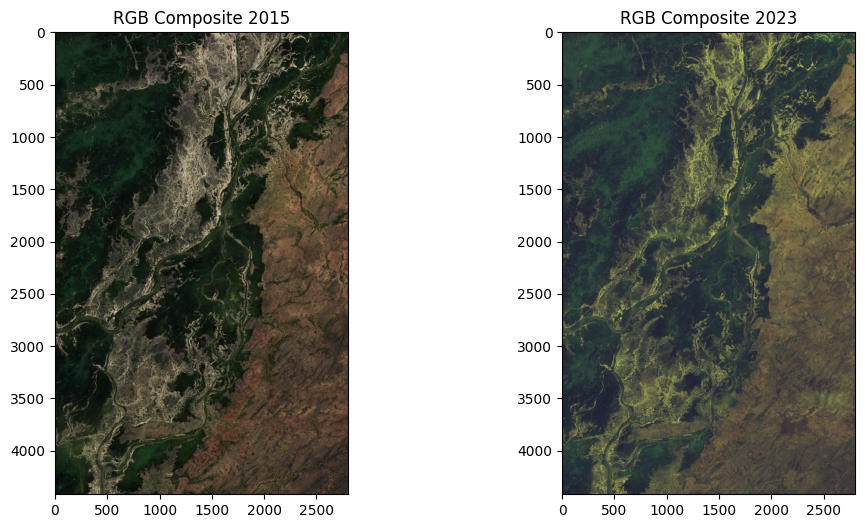

In [21]:
adjustment = 0.5 #Original RGB for 2023 appeared blue, this adjustment downscales the blue band 

# Create RGB natural color composite using the np.dstack function for 2023
rgb23 = np.dstack((redn23, greenn23, bluen23 * adjustment))

# Create RGB natural color composite using the np.dstack function for 2015
rgb15 = np.dstack((redn15, greenn15, bluen15))

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Visualize the RGB color composite for 2015
axes[0].imshow(rgb15)
axes[0].set_title('RGB Composite 2015')

# Visualize the RGB color composite for 2023
axes[1].imshow(rgb23)
axes[1].set_title('RGB Composite 2023')

plt.show()

A false colour composite can be created to visualise the vegetation cover. We will create a factor to modify the image appearance as the original image is quite dark

In [22]:
factor2023=3*np.mean(red_ROI_reflect23) 
factor2015=3*np.mean(red_ROI_reflect15) 

## Creating RGB natural color composites to visualise the vegetation cover for 2015 and 2023

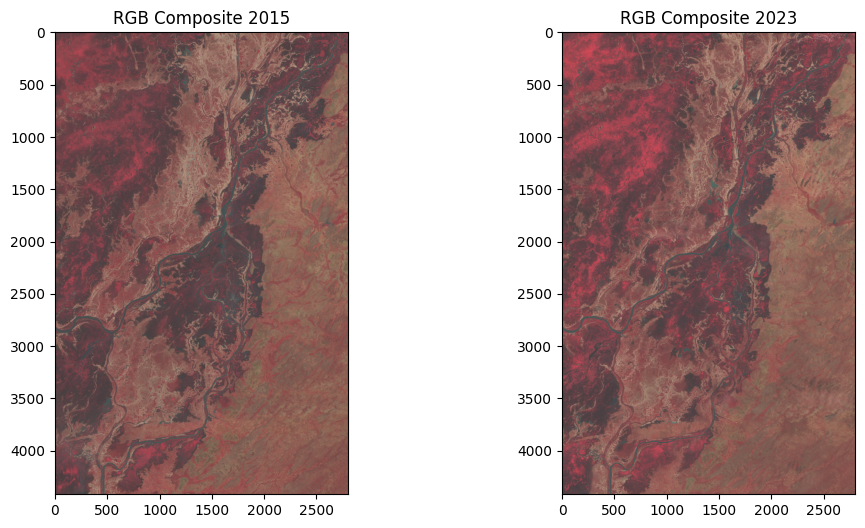

In [23]:
# Create false colour composite using the np.dstack function for 2023
falseColor2023 = np.dstack((nir_ROI_reflect23,red_ROI_reflect23,green_ROI_reflect23))/factor2023 #2023

# Create false color composite using the np.dstack function for 2015
falseColor2015= np.dstack((nir_ROI_reflect15,red_ROI_reflect15,green_ROI_reflect15))/factor2015 #2015

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Visualize the RGB color composite for 2015
axes[0].imshow(falseColor2015)
axes[0].set_title('RGB Composite 2015')

# Visualize the RGB color composite for 2023
axes[1].imshow(falseColor2023)
axes[1].set_title('RGB Composite 2023')

plt.show()

From a quick visual inspection, it appears that the vegetation is more dense in 2023 (more red pixels)

## Exploring NDVI changes

First we need to define a function to calculate NDVI

In [24]:
def ndvi(red, nir):
    """
    Calculate the NDVI given the red and NIR bands.
    
    Parameters:
    - red (numpy array): Red band values.
    - nir (numpy array): near-infrared band values.
    
    Returns:
    - numpy array: Calculated NDVI values
    """
    result = (nir - red) / (nir + red)
    return result

We can now use this function to calculate NDVI for 2023, 2015 and the overall NDVI change

In [25]:
ndvi_2023 = ndvi(red_ROI_reflect23, nir_ROI_reflect23) #2023 NDVI
ndvi_2015 = ndvi(red_ROI_reflect15, nir_ROI_reflect15) #2015 NDVI

ndvi_diff = ndvi_2015 - ndvi_2023 #NDVI difference from 2015 to 2023

We can plot the NDVI and NDVI change spatially

NDVI change plot saved as ndvi_difference.png


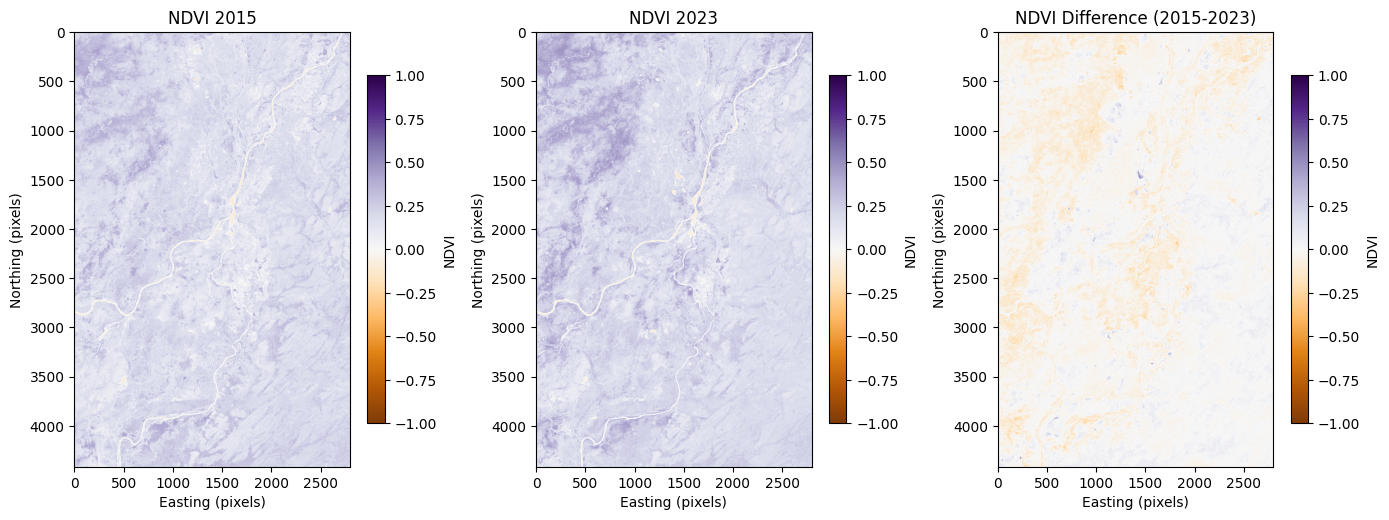

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(14, 9))

# First plot for NDVI 2015
img2 = axes[0].imshow(ndvi_2015, cmap="PuOr", vmin=-1, vmax=1)
axes[0].set_xlabel("Easting (pixels)")
axes[0].set_ylabel("Northing (pixels)")
axes[0].set_title("NDVI 2015")
plt.colorbar(img2, ax=axes[0], label="NDVI", shrink=0.4)

# Second plot for NDVI 2023
img1 = axes[1].imshow(ndvi_2023, cmap="PuOr", vmin=-1, vmax=1)
axes[1].set_xlabel("Easting (pixels)")
axes[1].set_ylabel("Northing (pixels)")
axes[1].set_title("NDVI 2023")
plt.colorbar(img1, ax=axes[1], label="NDVI", shrink=0.4)

# Third plot for the difference in NDVI
img3 = axes[2].imshow(ndvi_diff, cmap="PuOr", vmin=-1, vmax=1)
axes[2].set_xlabel("Easting (pixels)")
axes[2].set_ylabel("Northing (pixels)")
axes[2].set_title("NDVI Difference (2015-2023)")
plt.colorbar(img3, ax=axes[2], label="NDVI", shrink=0.4)

plt.tight_layout()  # Adjust layout for better spacing

#Saving the image as a PNG file
output_file_path = 'ndvi_difference.png'
plt.savefig(output_file_path, bbox_inches='tight')

print(f"NDVI change plot saved as {output_file_path}")

plt.show()

Calculate and print descriptive statistics for NDVI in 2023

In [27]:
# Descriptive statistics 2023
mean_value23 = np.mean(ndvi_2023)
median_value23 = np.median(ndvi_2023)
std_dev23 = np.std(ndvi_2023, ddof=1)  # Use ddof=1 for sample standard deviation
min_value23 = np.min(ndvi_2023)
max_value23 = np.max(ndvi_2023)
q1_23 = np.percentile(ndvi_2023, 25)
q3_23 = np.percentile(ndvi_2023, 75)

# Output the results 2023
print("Descriptive Statistics 2023:")
print("Mean:", mean_value23)
print("Median:", median_value23)
print("Standard Deviation:", std_dev23)
print("Minimum:", min_value23)
print("Maximum:", max_value23)
print("Q1 (25th Percentile):", q1_23)
print("Q3 (75th Percentile):", q3_23)

Descriptive Statistics 2023:
Mean: 0.20169133466941466
Median: 0.19278155555128557
Standard Deviation: 0.08730568666617403
Minimum: -0.1621719996029251
Maximum: 0.5232033515952303
Q1 (25th Percentile): 0.1483793348555424
Q3 (75th Percentile): 0.24656403878132116


Repating this for 2015

In [28]:
# Descriptive statistics 2015
mean_value15 = np.mean(ndvi_2015)
median_value15 = np.median(ndvi_2015)
std_dev15 = np.std(ndvi_2015, ddof=1)  # Use ddof=1 for sample standard deviation
min_value15 = np.min(ndvi_2015)
max_value15 = np.max(ndvi_2015)
q1_15 = np.percentile(ndvi_2015, 25)
q3_15 = np.percentile(ndvi_2015, 75)

# Output the results 2015
print("Descriptive Statistics 2015:")
print("Mean:", mean_value15)
print("Median:", median_value15)
print("Standard Deviation:", std_dev15)
print("Minimum:", min_value15)
print("Maximum:", max_value15)
print("Q1 (25th Percentile):", q1_15)
print("Q3 (75th Percentile):", q3_15)

Descriptive Statistics 2015:
Mean: 0.1831907052052662
Median: 0.18065140827353834
Standard Deviation: 0.07982022197622078
Minimum: -0.17669958907072306
Maximum: 0.5034654148833356
Q1 (25th Percentile): 0.1316441656537302
Q3 (75th Percentile): 0.2327140069568168


These statistics can be plotted graphically through box plots

NameError: name 'ndvi_data' is not defined

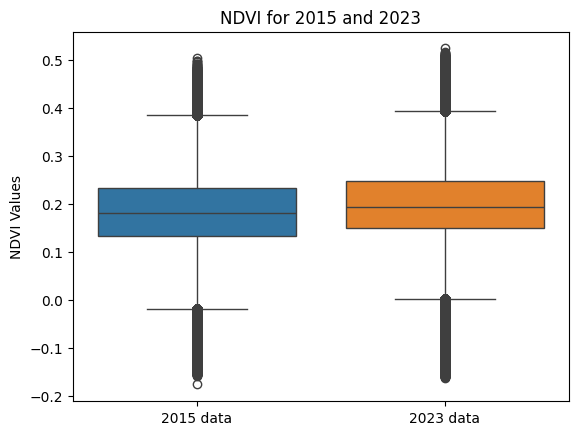

In [29]:
# Combine the data into a DataFrame for seaborn
df = pd.DataFrame({'2015 data': ndvi_2015.ravel(), '2023 data': ndvi_2023.ravel()})


# Create a boxplot using seaborn
sns.boxplot(data=df)
plt.title('NDVI for 2015 and 2023')
plt.ylabel('NDVI Values')
sns.boxplot(x=ndvi_data, boxprops=dict(facecolor='white', edgecolor='black'), flierprops=dict(markerfacecolor='red', marker='o'))

#Saving the plot as an image 
output_file_path = 'boxplot_ndvi.png'
plt.savefig(output_file_path, bbox_inches = 'tight')

print(f"Box plot saved as {output_file_path}")#Saving the plot as an image 


plt.show()

## Exploring the changes in vegetation types 

We will now explore the changes in shrub and grassland between 2015 to 2023.NDVI values between 0.2 and 0.5 are deemed representative of shrubs and grassland. 

In [30]:
#2023
NDVI_shrubs23 = np.sum((ndvi_2023 >= 0.2) & (ndvi_2023 <=0.5)) #NDVI representative of shrubs and grassland
NDVI_shrubs23_km2 = NDVI_shrubs23 * 30 ** 2 * 1e-6
NDVI_shrubs23_ac = NDVI_shrubs23_km2 * 247.10538161
print("Shrub area in 2023:", NDVI_shrubs23_km2, "km² /", NDVI_shrubs23_ac, "acres")

#2015
NDVI_shrubs15 = np.sum((ndvi_2015 >= 0.2) & (ndvi_2015 <=0.5)) #NDVI representative of shrubs and grassland
NDVI_shrubs15_km2 = NDVI_shrubs15 * 30 ** 2 * 1e-6
NDVI_shrubs15_ac = NDVI_shrubs15_km2 * 247.10538161
print("Shrub area in 2015:", NDVI_shrubs15_km2, "km² /", NDVI_shrubs15_ac, "acres")

#Difference change
shrubs_change_km2 = NDVI_shrubs23_km2 - NDVI_shrubs15_km2
shrubs_change_ac = NDVI_shrubs23_ac - NDVI_shrubs15_ac
print("Shrub area change since 2015:", shrubs_change_km2, "km² /", shrubs_change_ac, "acres")

#Percentage change
percentage_change_shrubs_km2 = round((shrubs_change_km2 / NDVI_shrubs15_km2) * 100, 2)
percentage_change_shrubs_ac = round((shrubs_change_ac / NDVI_shrubs15_ac) * 100, 2)
print("Percentage change in shrub area since 2015:", percentage_change_shrubs_km2,
      "% /", percentage_change_shrubs_ac, "%")

Shrub area in 2023: 5118.5304 km² / 1264816.4077743858 acres
Shrub area in 2015: 4428.4833 km² / 1094302.055800012 acres
Shrub area change since 2015: 690.0470999999998 km² / 170514.35197437368 acres
Percentage change in shrub area since 2015: 15.58 % / 15.58 %


We will now explore the change in dense vegetation between 2015 to 2023. NDVI values between 0.6 and 0.9 are deemed representative of dense vegetation

In [31]:
#2023
NDVI_dense23 = np.sum((ndvi_2023 >= 0.6) & (ndvi_2023 <=0.9)) #NDVI representative of dense vegetation
NDVI_dense23_km2 = NDVI_dense23 * 30 ** 2 * 1e-6
NDVI_dense23_ac = NDVI_dense23_km2 * 247.10538161
print("Dense vegetation area in 2023:", NDVI_dense23_km2, "km² /", NDVI_dense23_ac, "acres")

#2015
NDVI_dense15 = np.sum((ndvi_2015 >= 0.6) & (ndvi_2015 <=0.9)) #NDVI representative of dense vegetation
NDVI_dense15_km2 = NDVI_dense15 * 30 ** 2 * 1e-6
NDVI_dense15_ac = NDVI_dense15_km2 * 247.10538161
print("Dense vegetation area in 2015:", NDVI_dense15_km2, "km² /", NDVI_dense15_ac, "acres")

#Difference change
change_dense_km2 = NDVI_dense23_km2 - NDVI_dense15_km2
change_dense_ac = NDVI_dense23_ac - NDVI_dense15_ac
print("Dense vegetation area change since 2015:", change_dense_km2, "km² /", change_dense_ac, "acres")#Exploring the change in dense vegetation between 2015 to 2023

#Percentage change
percentage_change_dense_km2 = round((change_dense_km2 / NDVI_dense15_km2) * 100, 2)
percentage_change_dense_ac = round((change_dense_ac / NDVI_dense15_ac) * 100, 2)
print("Percentage change in dense vegetation area since 2015:", percentage_change_dense_km2,
      "% /", percentage_change_dense_ac, "%")

Dense vegetation area in 2023: 0.0 km² / 0.0 acres
Dense vegetation area in 2015: 0.0 km² / 0.0 acres
Dense vegetation area change since 2015: 0.0 km² / 0.0 acres
Percentage change in dense vegetation area since 2015: nan % / nan %


/var/folders/4v/3lt6t9r90bs_k0p4vlxnqccw0000gn/T/ipykernel_18815/1047595013.py:23: RuntimeWarning: invalid value encountered in scalar divide
  percentage_change_dense_km2 = round((change_dense_km2 / NDVI_dense15_km2) * 100, 2)
/var/folders/4v/3lt6t9r90bs_k0p4vlxnqccw0000gn/T/ipykernel_18815/1047595013.py:24: RuntimeWarning: invalid value encountered in scalar divide
  percentage_change_dense_ac = round((change_dense_ac / NDVI_dense15_ac) * 100, 2)


We will now explore the change in bare soil. NDVI values between 0 and 0.2 are deemed representative of bare soil

In [32]:
#2023
NDVI_bare23 = np.sum((ndvi_2023 >0) & (ndvi_2023 <=0.2)) #NDVI representative of bare soil
NDVI_bare23_km2 = NDVI_bare23 * 30 ** 2 * 1e-6
NDVI_bare23_ac = NDVI_bare23_km2 * 247.10538161
print("Bare soil area in 2023:", NDVI_bare23_km2, "km² /", NDVI_bare23_ac, "acres")

#2015
NDVI_bare15 = np.sum((ndvi_2015 > 0) & (ndvi_2015 <=0.2)) #NDVI representative of bare soil
NDVI_bare15_km2 = NDVI_bare15 * 30 ** 2 * 1e-6
NDVI_bare15_ac = NDVI_bare15_km2 * 247.10538161
print("Bare soil area in 2015:", NDVI_bare15_km2, "km² /", NDVI_bare15_ac, "acres")

#Difference change
change_bare_km2 = NDVI_bare23_km2 - NDVI_bare15_km2
change_bare_ac = NDVI_bare23_ac - NDVI_bare15_ac
print("Bare soil area change since 2015:", change_bare_km2, "km² /", change_bare_ac, "acres")

#Percentage change
percentage_change_bare_km2 = round((change_bare_km2 / NDVI_bare15_km2) * 100, 2)
percentage_change_bare_ac = round((change_bare_ac / NDVI_bare15_ac) * 100, 2)
print("Percentage change in bare soil area since 2015:", percentage_change_bare_km2,
      "% /", percentage_change_bare_ac, "%")

Bare soil area in 2023: 5841.7955999999995 km² / 1443539.1310256186 acres
Bare soil area in 2015: 6511.986 km² / 1609146.7855689775 acres
Bare soil area change since 2015: -670.1904000000004 km² / -165607.65454335883 acres
Percentage change in bare soil area since 2015: -10.29 % / -10.29 %


## Hypothesis Testing

We will perform a hypothesis test to assess the significance of change

**Null Hypothesis (H0):** There is no change in NDVI between 2015 and 2023

**Alternative Hypothesis (H1):** There is a significant change in NDVI between 2015 and 2023

A paired t-test is not possible, as the data bands violates the requirements, by not being normally distributed. Instead a Mann-Whitney U test is performed

In [33]:
# Perform Mann-Whitney U test
statistic, p_value = mannwhitneyu(ndvi_2023.ravel(), ndvi_2015.ravel())

# Check if any element in the p_value array is less than 0.05
if (p_value < 0.05):
    print(f"Reject the null hypothesis; p={p_value} there is a significant difference.")
else:
    print("Fail to reject the null hypothesis; there is no significant difference.")

Reject the null hypothesis; p=0.0 there is a significant difference.


## Sensitivity Studies - Exploring the effect of red band weighting on NDVI

Calculating the NDVI values for different red band weightings to its effects

In [34]:
# Adjust weighting factors
Scaling_factor25 = 1.25 #Weighting of a 25% increase
Scaling_factor50 = 1.50 #Weighting of a 50% increase
Scaling_factor100 = 2 #Weighting of a 100% increase

#Calculating the ndvi for each weighting of the red band

#25% increase in weighting
ndvi_2023_weight25 = ndvi(red_ROI_reflect23 * Scaling_factor25, nir_ROI_reflect23) #2023 NDVI
ndvi_2015_weight25 = ndvi(red_ROI_reflect15 * Scaling_factor25, nir_ROI_reflect15) #2015 NDVI
ndvi_diff_weight25 = ndvi_2015_weight25 - ndvi_2023_weight25 #NDVI difference from 2015 to 2023

#50% increase in weighting
ndvi_2023_weight50 = ndvi(red_ROI_reflect23 * Scaling_factor50, nir_ROI_reflect23) #2023 NDVI
ndvi_2015_weight50 = ndvi(red_ROI_reflect15 * Scaling_factor50, nir_ROI_reflect15) #2015 NDVI
ndvi_diff_weight50 = ndvi_2015_weight50 - ndvi_2023_weight50 #NDVI difference from 2015 to 2023

#100 increase in weighting
ndvi_2023_weight100 = ndvi(red_ROI_reflect23 * Scaling_factor100, nir_ROI_reflect23) #2023 NDVI
ndvi_2015_weight100 = ndvi(red_ROI_reflect15 * Scaling_factor100, nir_ROI_reflect15) #2015 NDVI
ndvi_diff_weight100 = ndvi_2015_weight100 - ndvi_2023_weight100 #NDVI difference from 2015 to 2023

These NDVI values can be plotted geospatially

Geospatial NDVI weightings saved as ndvi_weights.png


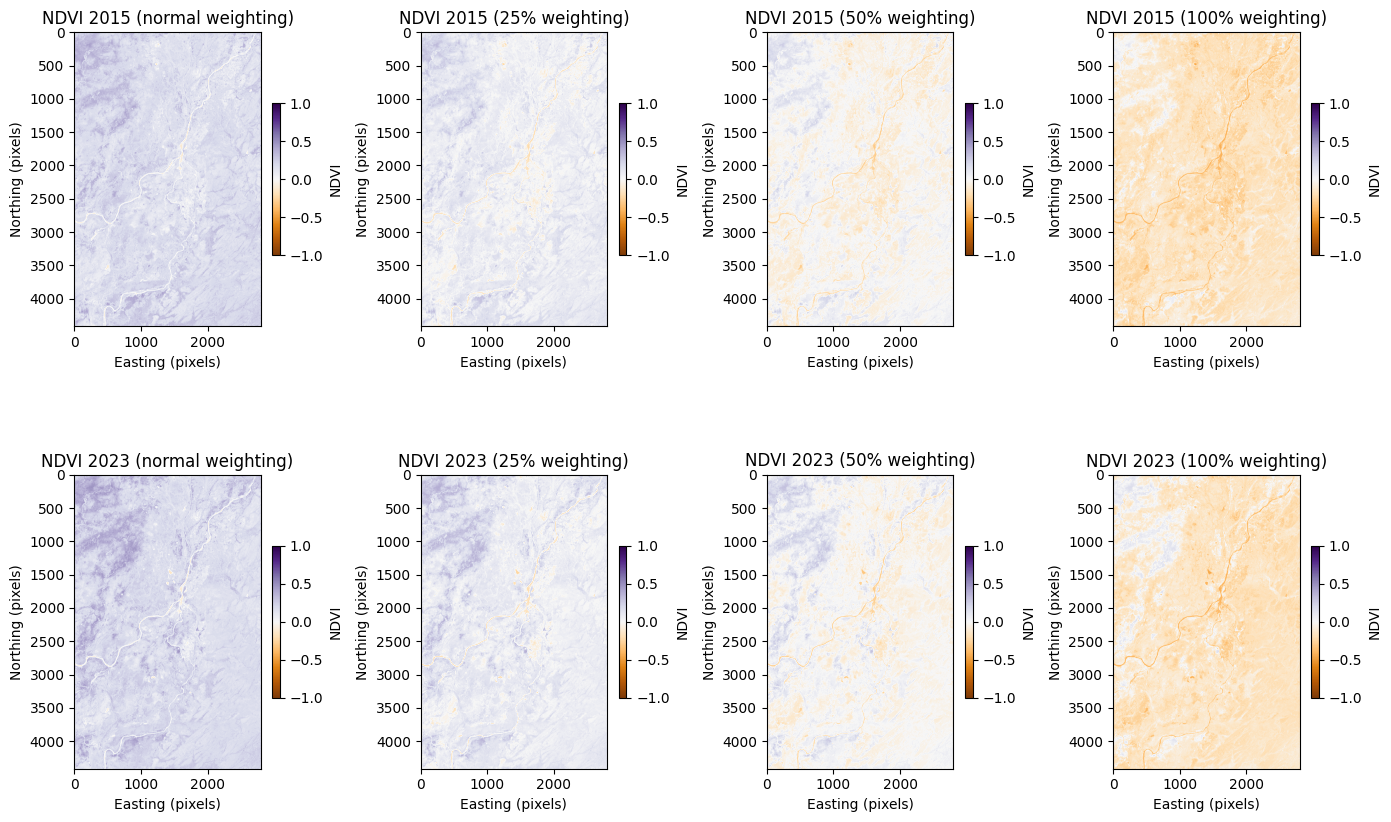

In [35]:
fig, axes = plt.subplots(2, 4, figsize=(14, 9))

#Normal weighting plots

#NDVI 2015 (normal red weighting)
img2 = axes[0,0].imshow(ndvi_2015, cmap="PuOr", vmin=-1, vmax=1)
axes[0,0].set_xlabel("Easting (pixels)")
axes[0,0].set_ylabel("Northing (pixels)")
axes[0,0].set_title("NDVI 2015 (normal weighting)")
plt.colorbar(img2, ax=axes[0,0], label="NDVI", shrink=0.4)

#NDVI 2023 (normal red weighting)
img1 = axes[1,0].imshow(ndvi_2023, cmap="PuOr", vmin=-1, vmax=1)
axes[1,0].set_xlabel("Easting (pixels)")
axes[1,0].set_ylabel("Northing (pixels)")
axes[1,0].set_title("NDVI 2023 (normal weighting)")
plt.colorbar(img1, ax=axes[1,0], label="NDVI", shrink=0.4)


##25% red weighting plots

# NDVI 2015 (25% red weighting)
img2 = axes[0,1].imshow(ndvi_2015_weight25, cmap="PuOr", vmin=-1, vmax=1)
axes[0,1].set_xlabel("Easting (pixels)")
axes[0,1].set_ylabel("Northing (pixels)")
axes[0,1].set_title("NDVI 2015 (25% weighting)")
plt.colorbar(img2, ax=axes[0,1], label="NDVI", shrink=0.4)

#NDVI 2023 (25% red weighting)
img1 = axes[1,1].imshow(ndvi_2023_weight25, cmap="PuOr", vmin=-1, vmax=1)
axes[1,1].set_xlabel("Easting (pixels)")
axes[1,1].set_ylabel("Northing (pixels)")
axes[1,1].set_title("NDVI 2023 (25% weighting)")
plt.colorbar(img1, ax=axes[1,1], label="NDVI", shrink=0.4)


##50% red weighting plots

# NDVI 2015 (50% red weighting)
img2 = axes[0,2].imshow(ndvi_2015_weight50, cmap="PuOr", vmin=-1, vmax=1)
axes[0,2].set_xlabel("Easting (pixels)")
axes[0,2].set_ylabel("Northing (pixels)")
axes[0,2].set_title("NDVI 2015 (50% weighting)")
plt.colorbar(img2, ax=axes[0,2], label="NDVI", shrink=0.4)

#NDVI 2023 (50% red weighting)
img1 = axes[1,2].imshow(ndvi_2023_weight50, cmap="PuOr", vmin=-1, vmax=1)
axes[1,2].set_xlabel("Easting (pixels)")
axes[1,2].set_ylabel("Northing (pixels)")
axes[1,2].set_title("NDVI 2023 (50% weighting)")
plt.colorbar(img1, ax=axes[1,2], label="NDVI", shrink=0.4)


##100% red weighting plots

# NDVI 2015 (100% red weighting)
img2 = axes[0,3].imshow(ndvi_2015_weight100, cmap="PuOr", vmin=-1, vmax=1)
axes[0,3].set_xlabel("Easting (pixels)")
axes[0,3].set_ylabel("Northing (pixels)")
axes[0,3].set_title("NDVI 2015 (100% weighting)")
plt.colorbar(img2, ax=axes[0,3], label="NDVI", shrink=0.4)

#NDVI 2023 (100% red weighting)
img1 = axes[1,3].imshow(ndvi_2023_weight100, cmap="PuOr", vmin=-1, vmax=1)
axes[1,3].set_xlabel("Easting (pixels)")
axes[1,3].set_ylabel("Northing (pixels)")
axes[1,3].set_title("NDVI 2023 (100% weighting)")
plt.colorbar(img1, ax=axes[1,3], label="NDVI", shrink=0.4)

plt.tight_layout()  # Adjust layout for better spacing 

#Saving the image as a PNG file
output_file_path = 'ndvi_weights.png'
plt.savefig(output_file_path, bbox_inches='tight')

print(f"Geospatial NDVI weightings saved as {output_file_path}")

#Show the plot
plt.show()

Exploring the change in bare soil with respect to red band weightings

In [36]:
#2023 (normal weighting)
print("Bare soil area in 2023 :", NDVI_bare23_km2, "km² /", NDVI_bare23_ac, "acres")

#2015 (normal weighting)
print("Bare soil area in 2015:", NDVI_bare15_km2, "km² /", NDVI_bare15_ac, "acres")

#2023 (25% weighting)
NDVI_bare23_weight25 = np.sum((ndvi_2023_weight25 > 0) & (ndvi_2023_weight25 <=0.2)) #NDVI representative of bare soil 
NDVI_bare23_weight25_km2 = NDVI_bare23_weight25 * 30 ** 2 * 1e-6
NDVI_bare23_weight25_ac = NDVI_bare23_weight25_km2 * 247.10538161
print("Bare soil area in 2023 (25% red band weighting) :", NDVI_bare23_weight25_km2, "km² /", NDVI_bare23_weight25_ac, "acres")

#2015 (25% weighting)
NDVI_bare15_weight25 = np.sum((ndvi_2015_weight25 > 0) & (ndvi_2015_weight25 <=0.2)) #NDVI representative of bare soil 
NDVI_bare15_weight25_km2 = NDVI_bare15_weight25 * 30 ** 2 * 1e-6
NDVI_bare15_weight25_ac = NDVI_bare15_weight25_km2 * 247.10538161
print("Bare soil area in 2015 (25% red band weighting) :", NDVI_bare15_weight25_km2, "km² /", NDVI_bare15_weight25_ac, "acres")

#2023 (50% weighting)
NDVI_bare23_weight50 = np.sum((ndvi_2023_weight50 > 0) & (ndvi_2023_weight50 <=0.2)) #NDVI representative of bare soil 
NDVI_bare23_weight50_km2 = NDVI_bare23_weight50 * 30 ** 2 * 1e-6
NDVI_bare23_weight50_ac = NDVI_bare23_weight50_km2 * 247.10538161
print("Bare soil area in 2023 (50% red band weighting) :", NDVI_bare23_weight50_km2, "km² /", NDVI_bare23_weight50_ac, "acres")

#2015 (50% weighting)
NDVI_bare15_weight50 = np.sum((ndvi_2015_weight50 > 0) & (ndvi_2015_weight50 <=0.2)) #NDVI representative of bare soil 
NDVI_bare15_weight50_km2 = NDVI_bare15_weight50 * 30 ** 2 * 1e-6
NDVI_bare15_weight50_ac = NDVI_bare15_weight50_km2 * 247.10538161
print("Bare soil area in 2015 (50% red band weighting) :", NDVI_bare15_weight50_km2, "km² /", NDVI_bare15_weight50_ac, "acres")

#2023 (100% weighting)
NDVI_bare23_weight100 = np.sum((ndvi_2023_weight100 > 0) & (ndvi_2023_weight100 <=0.2)) #NDVI representative of bare soil 
NDVI_bare23_weight100_km2 = NDVI_bare23_weight100 * 30 ** 2 * 1e-6
NDVI_bare23_weight100_ac = NDVI_bare23_weight100_km2 * 247.10538161
print("Bare soil area in 2023 (100% red band weighting) :", NDVI_bare23_weight100_km2, "km² /", NDVI_bare23_weight100_ac, "acres")

#2015 (100% weighting)
NDVI_bare15_weight100 = np.sum((ndvi_2015_weight100 > 0) & (ndvi_2015_weight100 <=0.2)) #NDVI representative of bare soil 
NDVI_bare15_weight100_km2 = NDVI_bare15_weight100 * 30 ** 2 * 1e-6
NDVI_bare15_weight100_ac = NDVI_bare15_weight100_km2 * 247.10538161
print("Bare soil area in 2015 (100% red band weighting) :", NDVI_bare15_weight100_km2, "km² /", NDVI_bare15_weight100_ac, "acres")

Bare soil area in 2023 : 5841.7955999999995 km² / 1443539.1310256186 acres
Bare soil area in 2015: 6511.986 km² / 1609146.7855689775 acres
Bare soil area in 2023 (25% red band weighting) : 8648.2917 km² / 2137039.4208030957 acres
Bare soil area in 2015 (25% red band weighting) : 8569.2231 km² / 2117501.144226727 acres
Bare soil area in 2023 (50% red band weighting) : 4703.7582 km² / 1162323.9650121666 acres
Bare soil area in 2015 (50% red band weighting) : 4347.0207 km² / 1074172.2089400694 acres
Bare soil area in 2023 (100% red band weighting) : 920.376 km² / 227429.86270468534 acres
Bare soil area in 2015 (100% red band weighting) : 396.96479999999997 km² / 98092.13838973732 acres


Exploring the change in shrub and grassland area between 2015 to 2023 with respect to red band weighting

In [37]:
#2023 (normal weighting)
print("Shrub area in 2023:", NDVI_shrubs23_km2, "km² /", NDVI_shrubs23_ac, "acres")

#2015 (normal weighting)
print("Shrub area in 2015:", NDVI_shrubs15_km2, "km² /", NDVI_shrubs15_ac, "acres")

#2023 (25% weighting)
NDVI_shrubs23_weight25 = np.sum((ndvi_2023_weight25 >=0.2) & (ndvi_2023_weight25 <=0.5)) 
NDVI_shrubs23_weight25_km2 = NDVI_shrubs23_weight25 * 30 ** 2 * 1e-6
NDVI_shrubs23_weight25_ac = NDVI_shrubs23_weight25_km2 * 247.10538161
print("Shrubs area in 2023 (25% red band weighting) :", NDVI_shrubs23_weight25_km2, "km² /", NDVI_shrubs23_weight25_ac, "acres")

#2015 (25% weighting)
NDVI_shrubs15_weight25 = np.sum((ndvi_2015_weight25 >=0.2) & (ndvi_2015_weight25 <=0.5)) 
NDVI_shrubs15_weight25_km2 = NDVI_shrubs15_weight25 * 30 ** 2 * 1e-6
NDVI_shrubs15_weight25_ac = NDVI_shrubs15_weight25_km2 * 247.10538161
print("Shrubs area in 2015 (25% red band weighting) :", NDVI_shrubs15_weight25_km2, "km² /", NDVI_shrubs15_weight25_ac, "acres")

#2023 (50% weighting)
NDVI_shrubs23_weight50 = np.sum((ndvi_2023_weight50 >=0.2) & (ndvi_2023_weight50 <=0.5)) 
NDVI_shrubs23_weight50_km2 = NDVI_shrubs23_weight50 * 30 ** 2 * 1e-6
NDVI_shrubs23_weight50_ac = NDVI_shrubs23_weight50_km2 * 247.10538161
print("Shrubs area in 2023 (50% red band weighting) :", NDVI_shrubs23_weight50_km2, "km² /", NDVI_shrubs23_weight50_ac, "acres")

#2015 (50% weighting)
NDVI_shrubs15_weight50 = np.sum((ndvi_2015_weight50 >=0.2) & (ndvi_2015_weight50 <=0.5)) 
NDVI_shrubs15_weight50_km2 = NDVI_shrubs15_weight50 * 30 ** 2 * 1e-6
NDVI_shrubs15_weight50_ac = NDVI_shrubs15_weight50_km2 * 247.10538161
print("Shrubs area in 2015 (50% red band weighting) :", NDVI_shrubs15_weight50_km2, "km² /", NDVI_shrubs15_weight50_ac, "acres")

#2023 (100% weighting)
NDVI_shrubs23_weight100 = np.sum((ndvi_2023_weight100 >=0.2) & (ndvi_2023_weight100 <=0.5)) 
NDVI_shrubs23_weight100_km2 = NDVI_shrubs23_weight100 * 30 ** 2 * 1e-6
NDVI_shrubs23_weight100_ac = NDVI_shrubs23_weight100_km2 * 247.10538161
print("Shrubs area in 2023 (100% red band weighting) :", NDVI_shrubs23_weight100_km2, "km² /", NDVI_shrubs23_weight100_ac, "acres")

#2015 (100% weighting)
NDVI_shrubs15_weight100 = np.sum((ndvi_2015_weight100 >=0.2) & (ndvi_2015_weight100 <=0.5)) 
NDVI_shrubs15_weight100_km2 = NDVI_shrubs15_weight100 * 30 ** 2 * 1e-6
NDVI_shrubs15_weight100_ac = NDVI_shrubs15_weight100_km2 * 247.10538161
print("Shrubs area in 2015 (100% red band weighting) :", NDVI_shrubs15_weight100_km2, "km² /", NDVI_shrubs15_weight100_ac, "acres")

Shrub area in 2023: 5118.5304 km² / 1264816.4077743858 acres
Shrub area in 2015: 4428.4833 km² / 1094302.055800012 acres
Shrubs area in 2023 (25% red band weighting) : 1327.9706999999999 km² / 328148.7065903988 acres
Shrubs area in 2015 (25% red band weighting) : 759.3588 km² / 187641.64605291164 acres
Shrubs area in 2023 (50% red band weighting) : 414.46349999999995 km² / 102416.16133091622 acres
Shrubs area in 2015 (50% red band weighting) : 81.1404 km² / 20050.229505988045 acres
Shrubs area in 2023 (100% red band weighting) : 0.0477 km² / 11.786926702797 acres
Shrubs area in 2015 (100% red band weighting) : 0.0009 km² / 0.22239484344899998 acres


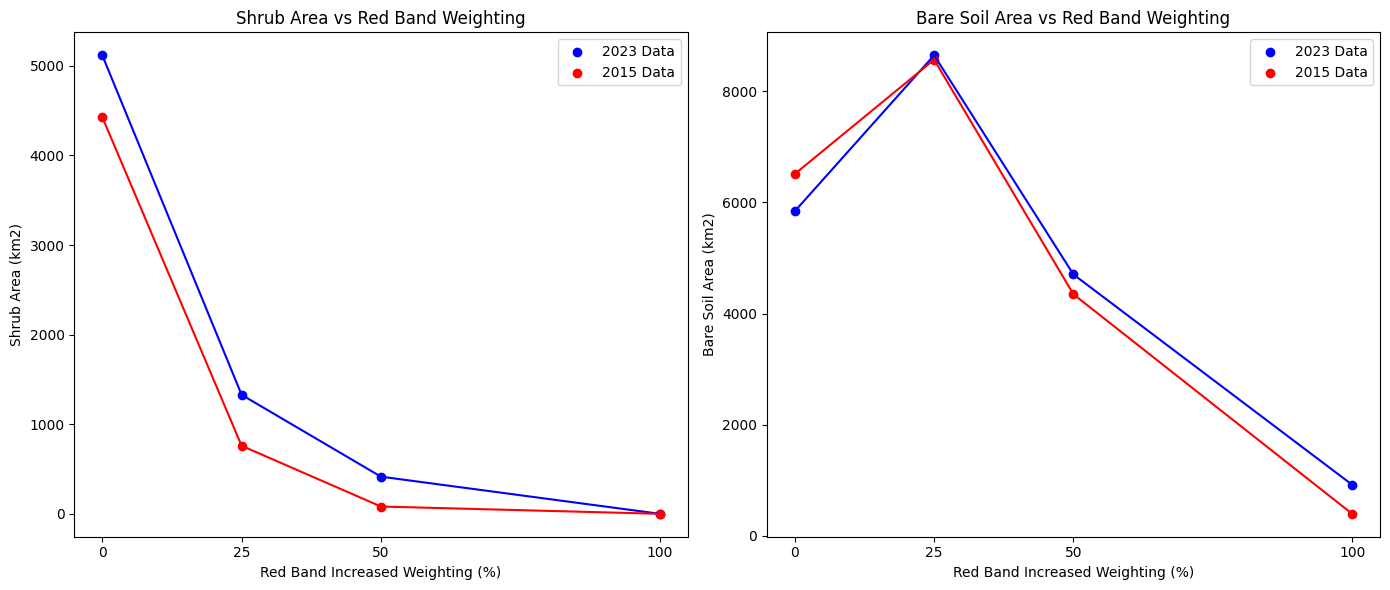

Line graph saved as red_band_weights.png


In [38]:
import matplotlib.pyplot as plt

red_band_weightings = [0, 25, 50, 100]
shrub_areas_2023 = [5118.5304, 1327.9707, 414.4635, 0.0477]
shrub_areas_2015 = [4428.4833, 759.3588, 81.1404, 0.0009]

bare_areas_2023 = [5841.5157, 8648.2728, 4703.7429, 920.376]
bare_areas_2015 = [6511.7277, 8569.2096, 4347.0081, 396.9648]

# Create a figure with two subplots arranged side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plotting for Shrub Area
axes[0].scatter(red_band_weightings, shrub_areas_2023, marker='o', color='blue', label='2023 Data')
axes[0].scatter(red_band_weightings, shrub_areas_2015, marker='o', color='red', label='2015 Data')
axes[0].plot(red_band_weightings, shrub_areas_2023, linestyle='-', color='blue')
axes[0].plot(red_band_weightings, shrub_areas_2015, linestyle='-', color='red')
axes[0].set_title('Shrub Area vs Red Band Weighting')
axes[0].set_xlabel('Red Band Increased Weighting (%)')
axes[0].set_ylabel('Shrub Area (km2)')
axes[0].grid(True)
axes[0].set_xticks(red_band_weightings)
axes[0].grid(False)
axes[0].legend()

# Plotting for Bare Soil Area
axes[1].scatter(red_band_weightings, bare_areas_2023, marker='o', color='blue', label='2023 Data')
axes[1].scatter(red_band_weightings, bare_areas_2015, marker='o', color='red', label='2015 Data')
axes[1].plot(red_band_weightings, bare_areas_2023, linestyle='-', color='blue')
axes[1].plot(red_band_weightings, bare_areas_2015, linestyle='-', color='red')
axes[1].set_title('Bare Soil Area vs Red Band Weighting')
axes[1].set_xlabel('Red Band Increased Weighting (%)')
axes[1].set_ylabel('Bare Soil Area (km2)')
axes[1].grid(True)
axes[1].set_xticks(red_band_weightings)
axes[1].grid(False)
axes[1].legend()

# Adjust layout for better spacing
plt.tight_layout()

#Saving the image as a PNG file
output_file_path = 'red_band_weights.png'
plt.savefig(output_file_path, bbox_inches='tight')

# Show the plot
plt.show()

print(f"Line graph saved as {output_file_path}")